# Библиотеки

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [35]:
import os
import torch
import torchvision
from torchvision.datasets import EMNIST
from torchvision import transforms
from torchvision.transforms import ToTensor, Compose, Resize, Normalize
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

import torchvision.transforms.functional as TF
import cv2
#import optuna

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Получение, трансформация, нормализация и контроль данных

In [36]:
# Определение трансформаций для нормализации данных
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Нормализация по среднему и стандартному отклонению
])

# Загрузка обучающего набора данных с трансформациями
train_data = EMNIST('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data', 'balanced', train=True, download=True,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

# Загрузка тестового набора данных с трансформациями
test_data = EMNIST('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data', 'balanced', train=False,
                transform=torchvision.transforms.Compose([ # Поворот и отражение
                    lambda img: torchvision.transforms.functional.rotate(img, -90),
                    lambda img: torchvision.transforms.functional.hflip(img),
                    transform # трансформируем и нормализуем
                ]))

In [37]:
# получение маппинга
with open('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/emnist-balanced-mapping.txt', 'r') as f:
    mapping = f.readlines()

#mapping

In [38]:
# Создаем словарь соответствий
label_dict = {}
for entry in mapping:
    label, ascii_code = map(int, entry.split())
    label_dict[label] = chr(ascii_code)

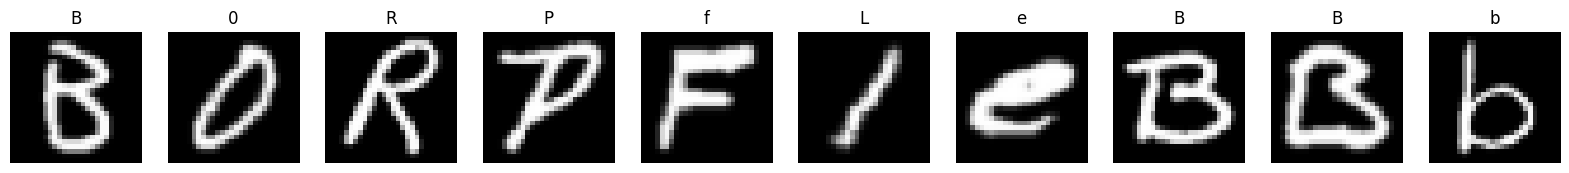

In [ ]:
# Проверяем корректность изображений
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.numpy()  # Прямое преобразование в NumPy массив

    # Убираем размерность канала (если она есть)
    if image_np.shape[0] == 1:  # Если канал один (черно-белое изображение)
        image_np = image_np.squeeze(0)  # Убираем размерность канала

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(label_dict[label])  # Используем словарь для отображения метки
    axs[i].axis('off')

plt.show()

In [39]:
# Создание загрузчиков данных
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)

In [ ]:
print(val_loader.batch_size)
train_loader.batch_size

64


64

In [ ]:

class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # размере после сверток и подвыборки
        self.fc2 = nn.Linear(256, 47)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 3 * 3)  # размер в зависимости от входного размера
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Инициализация модели и оптимизатора
model = ImprovedCNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# цикл обучения
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.7808
Validation Accuracy: 0.8627
Epoch 2/10, Loss: 0.4796
Validation Accuracy: 0.8694
Epoch 3/10, Loss: 0.4255
Validation Accuracy: 0.8741
Epoch 4/10, Loss: 0.3909
Validation Accuracy: 0.8813
Epoch 5/10, Loss: 0.3662
Validation Accuracy: 0.8839
Epoch 6/10, Loss: 0.3448
Validation Accuracy: 0.8807
Epoch 7/10, Loss: 0.3294
Validation Accuracy: 0.8870
Epoch 8/10, Loss: 0.3118
Validation Accuracy: 0.8845
Epoch 9/10, Loss: 0.3019
Validation Accuracy: 0.8857
Epoch 10/10, Loss: 0.2866
Validation Accuracy: 0.8897


In [ ]:
# Очищаем состояние для последующей модели
def clear_training_state(model, optimizer):
    # Удаляем все параметры и градиенты
    model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    optimizer.state.clear()  # Очищаем состояние оптимизатора
    optimizer.param_groups.clear()  # Очищаем группы параметров

In [ ]:
# Используем функцию для очистки состояния
#clear_training_state(model, optimizer)

# Функция потерь для многоклассовой классификации

In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), '/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data/model_din.ckpt')

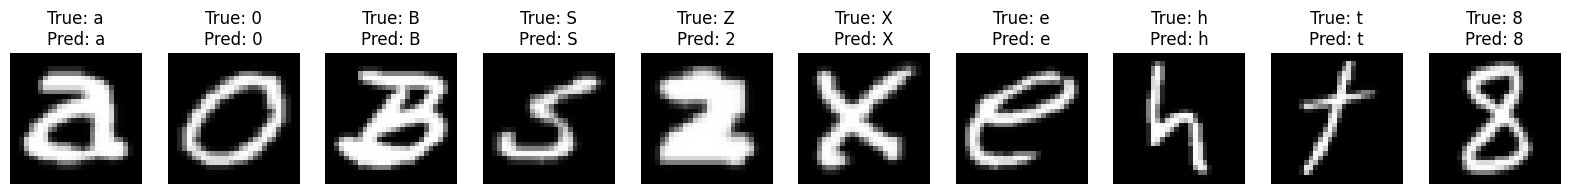

In [ ]:
def predict(image):
    # Применяем преобразования к изображению, если они требуются
    # image = transform(input_image)  # Примените необходимые преобразования
    # Убедитесь, что изображение имеет форму (1, 1, H, W) для модели
    if image.dim() == 2:  # Если изображение 2D (H, W)
        image = image.unsqueeze(0)  # Добавляем размер канала
    image = image.unsqueeze(0)  # Добавляем размер батча

    #print('image shape:', image.shape)

    with torch.no_grad():  # Отключаем градиенты для повышения производительности
        output = model(image)  # Получаем выход модели
        _, predicted_class = torch.max(output.data, 1)  # Находим класс с максимальной вероятностью
        predicted_label = predicted_class.item()  # Получаем метку класса как целое число
        #print('predicted_label:', predicted_label)

        pred = label_dict[predicted_label]  # Получаем предсказанную метку
        #print('predicted symbol:', pred)

    return pred

# Проверяем предсказания
fig, axs = plt.subplots(1, 10, figsize=(20, 5))
for i in range(10):
    random_index = np.random.randint(0, len(train_data))
    #print('Random index:', random_index)
    image, label = train_data[random_index]

    # Преобразование изображения в NumPy массив для корректного отображения
    image_np = image.squeeze(0).numpy()  # Убираем размер канала и преобразуем в NumPy массив

    pred = predict(image)  # Предсказание для изображения

    # Отображаем изображение
    axs[i].imshow(image_np, cmap='gray')  # Используем cmap='gray' для черно-белых изображений
    # Добавляем отображение истинной метки и предсказанного значения
    axs[i].set_title(f'True: {label_dict[label]}\nPred: {pred}')
    axs[i].axis('off')

plt.show()

In [ ]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # Предполагается, что ваша модель уже определена
model.load_state_dict(torch.load('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data/model_din.ckpt'))  # Замените на путь к вашей модели
model.eval()  # Установка модели в режим оценки

<ipython-input-74-e46f5af2341f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data/m

ImprovedCNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=47, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.81
1
Accuracy of class 1: 0.80
2
Accuracy of class 2: 0.92
3
Accuracy of class 3: 0.96
4
Accuracy of class 4: 0.92
5
Accuracy of class 5: 0.83
6
Accuracy of class 6: 0.94
7
Accuracy of class 7: 0.98
8
Accuracy of class 8: 0.98
9
Accuracy of class 9: 0.85
A
Accuracy of class 10: 0.98
B
Accuracy of class 11: 0.97
C
Accuracy of class 12: 0.96
D
Accuracy of class 13: 0.92
E
Accuracy of class 14: 0.98
F
Accuracy of class 15: 0.48
G
Accuracy of class 16: 0.95
H
Accuracy of class 17: 0.99
I
Accuracy of class 18: 0.64
J
Accuracy of class 19: 0.96
K
Accuracy of class 20: 0.97
L
Accuracy of class 21: 0.45
M
Accuracy of class 22: 0.98
N
Accuracy of class 23: 0.98
O
Accuracy of class 24: 0.57
P
Accuracy of class 25: 0.98
Q
Accuracy of class 26: 0.94
R
Accuracy of class 27: 0.98
S
Accuracy of class 28: 0.97
T
Accuracy of class 29: 0.94
U
Accuracy of class 30: 0.93
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.98
Y
Accuracy of class 34: 

In [ ]:
# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.81
1
Accuracy of class 1: 0.80
2
Accuracy of class 2: 0.92
3
Accuracy of class 3: 0.96
4
Accuracy of class 4: 0.92
5
Accuracy of class 5: 0.83
6
Accuracy of class 6: 0.94
7
Accuracy of class 7: 0.98
8
Accuracy of class 8: 0.98
9
Accuracy of class 9: 0.85
A
Accuracy of class 10: 0.98
B
Accuracy of class 11: 0.97
C
Accuracy of class 12: 0.96
D
Accuracy of class 13: 0.92
E
Accuracy of class 14: 0.98
F
Accuracy of class 15: 0.48
G
Accuracy of class 16: 0.95
H
Accuracy of class 17: 0.99
I
Accuracy of class 18: 0.64
J
Accuracy of class 19: 0.96
K
Accuracy of class 20: 0.97
L
Accuracy of class 21: 0.45
M
Accuracy of class 22: 0.98
N
Accuracy of class 23: 0.98
O
Accuracy of class 24: 0.57
P
Accuracy of class 25: 0.98
Q
Accuracy of class 26: 0.94
R
Accuracy of class 27: 0.98
S
Accuracy of class 28: 0.97
T
Accuracy of class 29: 0.94
U
Accuracy of class 30: 0.93
V
Accuracy of class 31: 0.94
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.98
Y
Accuracy of class 34: 

In [ ]:
# Проверяем, доступен ли GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемый устройство: {device}")

Используемый устройство: cuda


In [ ]:
# Определение модели
class ImprovedCNNModel(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Изменяем размер fc1 в зависимости от входного размера
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 47)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        x = x.view(-1, 128 * 3 * 3)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [ ]:
# Инициализация модели и оптимизатора
model = ImprovedCNNModel()#.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.00218)
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Функция для обучения и валидации модели
def objective(trial):
    # Подбор гиперпараметров
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)

    model = ImprovedCNNModel(dropout_rate=dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    # Загрузка данных
    #transform = transforms.Compose([
        #transforms.Resize((28, 28)),
        #transforms.ToTensor(),
    #])

    #train_dataset = datasets.EMNIST(root='./data', split='letters', train=True,
                                     #download=True, transform=transform)
    #val_dataset = datasets.EMNIST(root='./data', split='letters', train=False,
                                   #download=True, transform=transform)

    #train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    #val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Обучение модели
    n_epochs = 5
    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0

        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    # Валидация модели
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)

    return accuracy

In [ ]:
# Запуск оптимизации гиперпараметров с помощью Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Вывод лучших гиперпараметров
print("Best hyperparameters: ", study.best_params)
print("Best accuracy: ", study.best_value)

[I 2025-01-03 11:28:15,579] A new study created in memory with name: no-name-5e2e1e0f-cc99-41db-b936-2fdde81978df
<ipython-input-14-a4d53927d514>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
[I 2025-01-03 11:44:58,900] Trial 0 finished with value: 0.8798404255319149 and parameters: {'dropout_rate': 0.30540906788124494, 'lr': 0.0021843695129641185}. Best is trial 0 with value: 0.8798404255319149.
[I 2025-01-03 12:01:44,151] Trial 1 finished with value: 0.8789361702127659 and parameters: {'dropout_rate': 0.3531347456105278, 'lr': 0.00013372793504250568}. Best is trial 0 with value: 0.8798404255319149.


In [ ]:
dropout_rate = 0.30540906788124
lr = 0.002184369512

In [ ]:
# цикл обучения
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.8978
Validation Accuracy: 0.8318
Epoch 2/10, Loss: 0.5731
Validation Accuracy: 0.8598
Epoch 3/10, Loss: 0.5038
Validation Accuracy: 0.8747
Epoch 4/10, Loss: 0.4621
Validation Accuracy: 0.8716
Epoch 5/10, Loss: 0.4274
Validation Accuracy: 0.8730
Epoch 6/10, Loss: 0.4021
Validation Accuracy: 0.8778
Epoch 7/10, Loss: 0.3829
Validation Accuracy: 0.8838
Epoch 8/10, Loss: 0.3667
Validation Accuracy: 0.8779
Epoch 9/10, Loss: 0.3504
Validation Accuracy: 0.8811
Epoch 10/10, Loss: 0.3365
Validation Accuracy: 0.8827


In [ ]:
# Загрузка предварительно обученной модели
model = ImprovedCNNModel()  # Предполагается, что ваша модель уже определена
#model.load_state_dict(torch.load('/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data/model_din.ckpt'))
model.load_state_dict(torch.load('/content/drive/MyDrive/Scientist/Advanced/practice-cnn/myapp/model_from_archive.ckpt'))# Замените на путь к вашей модели
model.eval()

<ipython-input-83-b163e93553a2>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/Scientist/Advanced/practice-cnn/mya

RuntimeError: Error(s) in loading state_dict for ImprovedCNNModel:
	Missing key(s) in state_dict: "conv1.weight", "conv1.bias", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "conv2.weight", "conv2.bias", "bn2.weight", "bn2.bias", "bn2.running_mean", "bn2.running_var", "conv3.weight", "conv3.bias", "bn3.weight", "bn3.bias", "bn3.running_mean", "bn3.running_var", "fc1.weight", "fc1.bias", "fc2.weight", "fc2.bias". 
	Unexpected key(s) in state_dict: "fc.0.weight", "fc.0.bias", "fc.3.weight", "fc.3.bias", "conv1.0.weight", "conv1.0.bias", "conv2.0.weight", "conv2.0.bias". 

In [ ]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.66
1
Accuracy of class 1: 0.82
2
Accuracy of class 2: 0.90
3
Accuracy of class 3: 0.98
4
Accuracy of class 4: 0.94
5
Accuracy of class 5: 0.89
6
Accuracy of class 6: 0.93
7
Accuracy of class 7: 0.99
8
Accuracy of class 8: 0.97
9
Accuracy of class 9: 0.91
A
Accuracy of class 10: 0.97
B
Accuracy of class 11: 0.96
C
Accuracy of class 12: 0.97
D
Accuracy of class 13: 0.91
E
Accuracy of class 14: 0.97
F
Accuracy of class 15: 0.50
G
Accuracy of class 16: 0.95
H
Accuracy of class 17: 0.97
I
Accuracy of class 18: 0.63
J
Accuracy of class 19: 0.94
K
Accuracy of class 20: 0.96
L
Accuracy of class 21: 0.37
M
Accuracy of class 22: 0.98
N
Accuracy of class 23: 0.97
O
Accuracy of class 24: 0.70
P
Accuracy of class 25: 0.95
Q
Accuracy of class 26: 0.94
R
Accuracy of class 27: 0.95
S
Accuracy of class 28: 0.95
T
Accuracy of class 29: 0.94
U
Accuracy of class 30: 0.95
V
Accuracy of class 31: 0.90
W
Accuracy of class 32: 0.99
X
Accuracy of class 33: 0.96
Y
Accuracy of class 34: 

In [ ]:
# Сохранение модели в формате .ckpt
torch.save(model.state_dict(), '/content/drive/MyDrive/Scientist/Advanced/torch_cnn/data/model_opt.ckpt')

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Scientist/Advanced/practice-cnn/myapp/model_from_archive.ckpt')
print(checkpoint.keys())  # Вывод ключей в контрольной точке

odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias'])


<ipython-input-16-e6bd94ed5c61>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/drive/MyDrive/Scientist/Advanced/practice-cnn/myapp/model_

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Определение модели (пример)
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Например, для 10 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка контрольной точки
checkpoint_path = '/content/drive/MyDrive/Scientist/Advanced/practice-cnn/myapp/model_from_archive.ckpt'
checkpoint = torch.load(checkpoint_path)

# Создание экземпляра модели
model = ImprovedCNNModel()

# Загрузка параметров с использованием strict=False для игнорирования отсутствующих ключей
try:
    model.load_state_dict(checkpoint, strict=False)  # Загрузка без строгого соответствия ключей
except RuntimeError as e:
    print("Ошибка при загрузке state_dict:", e)

# Установка режима оценки
model.eval()

# Пример использования модели для предсказаний (замените на ваши данные)
input_data = torch.randn(1, 1, 28, 28)   # Пример входного тензора
output = model(input_data)

print("Output shape:", output.shape)

Output shape: torch.Size([1, 47])


<ipython-input-40-a1d4adf2897c>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [41]:
# Получение всех параметров модели
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Parameter shape: {param.shape}")

Parameter name: conv1.weight, Parameter shape: torch.Size([32, 1, 3, 3])
Parameter name: conv1.bias, Parameter shape: torch.Size([32])
Parameter name: bn1.weight, Parameter shape: torch.Size([32])
Parameter name: bn1.bias, Parameter shape: torch.Size([32])
Parameter name: conv2.weight, Parameter shape: torch.Size([64, 32, 3, 3])
Parameter name: conv2.bias, Parameter shape: torch.Size([64])
Parameter name: bn2.weight, Parameter shape: torch.Size([64])
Parameter name: bn2.bias, Parameter shape: torch.Size([64])
Parameter name: fc1.weight, Parameter shape: torch.Size([128, 3136])
Parameter name: fc1.bias, Parameter shape: torch.Size([128])
Parameter name: fc2.weight, Parameter shape: torch.Size([47, 128])
Parameter name: fc2.bias, Parameter shape: torch.Size([47])


In [42]:
print(model)

ImprovedCNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=47, bias=True)
)


In [43]:
# Вывод ключей в контрольной точке
print("Keys in checkpoint:", checkpoint.keys())

# Если есть дополнительные метаданные
if 'optimizer_state_dict' in checkpoint:
    print("Optimizer state dict keys:", checkpoint['optimizer_state_dict'].keys())
if 'epoch' in checkpoint:
    print("Epoch:", checkpoint['epoch'])
if 'loss' in checkpoint:
    print("Last recorded loss:", checkpoint['loss'])

Keys in checkpoint: odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias'])


In [45]:
if 'train_metrics' in checkpoint:
    print("Training metrics:", checkpoint['train_metrics'])

In [46]:
checkpoint = torch.load(checkpoint_path, weights_only=True)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Определение модели (пример)
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Например, для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Загрузка контрольной точки
checkpoint_path = '/content/drive/MyDrive/Scientist/Advanced/practice-cnn/myapp/model_from_archive.ckpt'
checkpoint = torch.load(checkpoint_path)

# Создание экземпляра модели
model = ImprovedCNNModel()

# Загрузка параметров с использованием strict=False для игнорирования отсутствующих ключей
try:
    model.load_state_dict(checkpoint, strict=False)  # Загрузка без строгого соответствия ключей
except RuntimeError as e:
    print("Ошибка при загрузке state_dict:", e)

# Установка режима оценки
model.eval()

# Извлечение информации о параметрах модели
print("Model parameters:")
for name, param in model.named_parameters():
    print(f"Parameter name: {name}, Parameter shape: {param.shape}")

# Изучение содержимого контрольной точки
print("Keys in checkpoint:", checkpoint.keys())
if 'optimizer_state_dict' in checkpoint:
    print("Optimizer state dict keys:", checkpoint['optimizer_state_dict'].keys())
if 'epoch' in checkpoint:
    print("Epoch:", checkpoint.get('epoch', 'Not available'))
if 'loss' in checkpoint:
    print("Last recorded loss:", checkpoint.get('loss', 'Not available'))

# Пример использования модели для предсказаний (замените на ваши данные)
input_data = torch.randn(1, 1, 28, 28)   # Пример входного тензора
output = model(input_data)

print("Output shape:", output.shape)

print(model)

Model parameters:
Parameter name: conv1.weight, Parameter shape: torch.Size([32, 1, 3, 3])
Parameter name: conv1.bias, Parameter shape: torch.Size([32])
Parameter name: bn1.weight, Parameter shape: torch.Size([32])
Parameter name: bn1.bias, Parameter shape: torch.Size([32])
Parameter name: conv2.weight, Parameter shape: torch.Size([64, 32, 3, 3])
Parameter name: conv2.bias, Parameter shape: torch.Size([64])
Parameter name: bn2.weight, Parameter shape: torch.Size([64])
Parameter name: bn2.bias, Parameter shape: torch.Size([64])
Parameter name: fc1.weight, Parameter shape: torch.Size([128, 3136])
Parameter name: fc1.bias, Parameter shape: torch.Size([128])
Parameter name: fc2.weight, Parameter shape: torch.Size([47, 128])
Parameter name: fc2.bias, Parameter shape: torch.Size([47])
Keys in checkpoint: odict_keys(['conv1.0.weight', 'conv1.0.bias', 'conv2.0.weight', 'conv2.0.bias', 'fc.0.weight', 'fc.0.bias', 'fc.3.weight', 'fc.3.bias'])
Output shape: torch.Size([1, 47])
ImprovedCNNModel(
 

<ipython-input-48-ffce7553f2ac>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [34]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.00
1
Accuracy of class 1: 0.00
2
Accuracy of class 2: 0.00
3
Accuracy of class 3: 0.00
4
Accuracy of class 4: 0.00
5
Accuracy of class 5: 0.00
6
Accuracy of class 6: 0.00
7
Accuracy of class 7: 0.69
8
Accuracy of class 8: 0.00
9
Accuracy of class 9: 0.00
A
Accuracy of class 10: 0.00
B
Accuracy of class 11: 0.00
C
Accuracy of class 12: 0.01
D
Accuracy of class 13: 0.00
E
Accuracy of class 14: 0.00
F
Accuracy of class 15: 0.00
G
Accuracy of class 16: 0.00
H
Accuracy of class 17: 0.11
I
Accuracy of class 18: 0.00
J
Accuracy of class 19: 0.00
K
Accuracy of class 20: 0.00
L
Accuracy of class 21: 0.00
M
Accuracy of class 22: 0.00
N
Accuracy of class 23: 0.00
O
Accuracy of class 24: 0.00
P
Accuracy of class 25: 0.00
Q
Accuracy of class 26: 0.00
R
Accuracy of class 27: 0.00
S
Accuracy of class 28: 0.00
T
Accuracy of class 29: 0.66
U
Accuracy of class 30: 0.00
V
Accuracy of class 31: 0.00
W
Accuracy of class 32: 0.00
X
Accuracy of class 33: 0.01
Y
Accuracy of class 34: 

In [49]:
# Определение модели
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Убедитесь в правильном размере
        self.fc2 = nn.Linear(128, 47)  # Для 47 классов

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [50]:
# Инициализация модели и оптимизатора
model = ImprovedCNNModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# Обучение модели
n_epochs = 10

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0

    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{n_epochs}, Loss: {running_loss / len(train_loader):.4f}')

    # Валидация модели после каждой эпохи
    model.eval()
    correct = 0

    with torch.no_grad():
        for data, target in val_loader:
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()

    accuracy = correct / len(val_loader.dataset)
    print(f'Validation Accuracy: {accuracy:.4f}')

Epoch 1/10, Loss: 0.6457
Validation Accuracy: 0.8380
Epoch 2/10, Loss: 0.4101
Validation Accuracy: 0.8569
Epoch 3/10, Loss: 0.3620
Validation Accuracy: 0.8680
Epoch 4/10, Loss: 0.3293
Validation Accuracy: 0.8720
Epoch 5/10, Loss: 0.3046
Validation Accuracy: 0.8709
Epoch 6/10, Loss: 0.2840
Validation Accuracy: 0.8707
Epoch 7/10, Loss: 0.2623
Validation Accuracy: 0.8763
Epoch 8/10, Loss: 0.2479
Validation Accuracy: 0.8738
Epoch 9/10, Loss: 0.2336
Validation Accuracy: 0.8732
Epoch 10/10, Loss: 0.2188
Validation Accuracy: 0.8722


In [51]:

# Инициализация переменных для хранения результатов
class_correct = [0] * 47  # Для каждого из 47 классов
class_total = [0] * 47

# Оценка модели на тестовом наборе данных
with torch.no_grad():
    for data, target in val_loader:
        output = model(data)  # Получение предсказаний от модели
        _, predicted = torch.max(output, 1)  # Получение индексов классов с максимальным значением вероятности

        # Подсчет правильных предсказаний для каждого класса
        for i in range(len(target)):
            label = target[i].item()  # Получение метки класса
            class_correct[label] += (predicted[i] == label).item()  # Увеличение счетчика для правильного предсказания
            class_total[label] += 1  # Увеличение общего количества примеров для данного класса

# Вывод результатов по каждому классу
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        print(label_dict[i])
        print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')

0
Accuracy of class 0: 0.84
1
Accuracy of class 1: 0.69
2
Accuracy of class 2: 0.86
3
Accuracy of class 3: 0.98
4
Accuracy of class 4: 0.91
5
Accuracy of class 5: 0.85
6
Accuracy of class 6: 0.95
7
Accuracy of class 7: 0.99
8
Accuracy of class 8: 0.93
9
Accuracy of class 9: 0.65
A
Accuracy of class 10: 0.91
B
Accuracy of class 11: 0.95
C
Accuracy of class 12: 0.96
D
Accuracy of class 13: 0.88
E
Accuracy of class 14: 0.96
F
Accuracy of class 15: 0.55
G
Accuracy of class 16: 0.95
H
Accuracy of class 17: 0.91
I
Accuracy of class 18: 0.54
J
Accuracy of class 19: 0.94
K
Accuracy of class 20: 0.97
L
Accuracy of class 21: 0.57
M
Accuracy of class 22: 0.97
N
Accuracy of class 23: 0.96
O
Accuracy of class 24: 0.53
P
Accuracy of class 25: 0.97
Q
Accuracy of class 26: 0.90
R
Accuracy of class 27: 0.98
S
Accuracy of class 28: 0.95
T
Accuracy of class 29: 0.87
U
Accuracy of class 30: 0.91
V
Accuracy of class 31: 0.93
W
Accuracy of class 32: 0.98
X
Accuracy of class 33: 0.94
Y
Accuracy of class 34: 

In [ ]:
# Вывод результатов по каждому классу с accuracy < 0.87
print("Classes with accuracy < 0.87:")
for i in range(47):
    if class_total[i] > 0:  # Избегаем деления на ноль
        accuracy = class_correct[i] / class_total[i]
        if accuracy < 0.87:  # Проверяем условие на точность
            print(label_dict[i])  # Выводим метку класса
            print(f'Accuracy of class {i}: {accuracy:.2f}')
    else:
        print(f'Class {i} has no samples in the test set.')